In [29]:
import pandas as pd
import numpy as np
import os
import openpyxl

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


In [7]:
# importowanie danych

excel_file = 'C:/Users/lysyy/PycharmProjects/xg/wybory_1.xlsx'

In [37]:
dane = {}

xl = pd.ExcelFile(excel_file)
for sheet_name in xl.sheet_names:
    dane[sheet_name] = pd.read_excel(excel_file, sheet_name=sheet_name)

for name, df in list(dane.items()):
    print(f"\nArkusz: {name}")
    print(df.head(2))



Arkusz: 2000 wyniki
          Imię i nazwisko  Wiek Wykształcenie  \
0  Aleksander Kwaśniewski  45.0       średnie   
1      Andrzej Olechowski  53.0   wyższe (dr)   

  Przynależność partyjna i poparcie partii      Głosy Procent  Poglądy  
0                              bezpartyjny  9 485 224  53,90%   lewica  
1                              bezpartyjny  3 044 141  17,30%  centrum  

Arkusz: 2000 sondaże
  Source (2000)          Date (2000)  Kwaśniewski (2000)  Olechowski (2000)  \
0          CBOS      Sept.-Oct. 2000                  55                 13   
1          CBOS  2000-09-01 00:00:00                  62                 10   

   Krzaklewski (2000) Kalinowski (2000)  Lepper (2000)  Korwin (2000)  \
0                   7                 6              3              1   
1                   7                 5              2              2   

   Wałęsa (2000) Łopuszański (2000) Grabowski (2000) Ikonowicz (2000)  \
0              1                  1                0       

In [41]:
sondaze_2025 = pd.read_excel(excel_file, sheet_name = '2025 sondaże')

print(sondaze_2025.head())

                   Source (2025)          Date (2025)  Nawrocki (2025)  \
0       IBRiS / Polskie Radio 24       10–11 May 2025             23.6   
1             Pollster / "SE.pl"         7–8 May 2025             22.7   
2         United Surveys / WP.pl  2025-05-07 00:00:00             23.2   
3  Opinia24 / "Fakty" TVN, TVN24         6–7 May 2025             25.0   
4         United Surveys / WP.pl       28–29 Apr 2025             24.7   

   Trzaskowski (2025)  Hołownia (2025)  Biejat (2025)  Zandberg (2025)  \
0               31.50             8.60           6.30             5.40   
1               32.26             8.36           5.52             7.21   
2               33.20             7.50           6.10             3.70   
3               31.00             5.00           6.00             5.00   
4               31.60             8.00           5.60             4.30   

   Mentzen (2025)  Braun (2025)  Jakubiak (2025)  Stanowski (2025)  \
0           12.60           2.6         

In [ ]:
for col in sondaze_2025.columns[4:]:
    sondaze_2025[col] = pd.to_numeric(sondaze_2025[col], errors = 'coerce')

sondaze_2025.dropna(axis = 1, how = 'all', inplace = True)
print(sondaze_2025)

In [43]:
# Pomijamy pierwsze kolumny z metadanymi, bierzemy tylko kolumny kandydatów
kandydaci = sondaze_2025.columns[3:-3]  # pomijamy ostatnie kolumny jak "Don't know", "Lead" itp.

# Obliczamy średnie poparcie (z wyłączeniem NaN)
srednie_poparcie = sondaze_2025[kandydaci].mean().sort_values(ascending=False)

print("Średnie poparcie kandydatów w sondażach 2025:")
print(srednie_poparcie)


Średnie poparcie kandydatów w sondażach 2025:
Trzaskowski (2025)     34.484789
Mentzen (2025)         14.516338
Hołownia (2025)         6.932817
Biejat (2025)           3.611304
Zandberg (2025)         2.789048
Braun (2025)            2.483333
Stanowski (2025)        1.965918
Jakubiak (2025)         1.415692
Senyszyn (2025)         0.708800
Bartoszewicz (2025)     0.681176
Maciak (2025)           0.192667
Woch (2025)             0.119167
dtype: float64


In [47]:
lata = [2000, 2005, 2010, 2015, 2020]


In [49]:
for rok in lata:
    print(f'\nRok {rok} - kolumny:')
    print(dane[f'{rok} wyniki'].columns)



Rok 2000 - kolumny:
Index(['Imię i nazwisko', 'Wiek', 'Wykształcenie',
       'Przynależność partyjna i poparcie partii', 'Głosy', 'Procent',
       'Poglądy'],
      dtype='object')

Rok 2005 - kolumny:
Index(['Imię i nazwisko', 'Wiek', 'Wykształcenie',
       'Przynależność partyjna i poparcie partii', 'Głosy', 'Procent',
       'Poglady'],
      dtype='object')

Rok 2010 - kolumny:
Index(['Imię i nazwisko', 'Wiek', 'Wykształcenie', 'Przynależność partyjna',
       'Głosy', 'Procent', 'Poglądy'],
      dtype='object')

Rok 2015 - kolumny:
Index(['Imię i nazwisko', 'Wiek', 'Wykształcenie', 'Przynależność partyjna',
       'Głosy', 'Procent', 'Poglądy'],
      dtype='object')

Rok 2020 - kolumny:
Index(['Imiona i nazwisko', 'Wiek', 'Wykształcenie', 'Przynależność partyjna',
       'Głosy', 'Procent', 'Poglądy'],
      dtype='object')


In [51]:
lata = [2000, 2005, 2010, 2015, 2020]
wszystkie_wyniki = []

for rok in lata:
    df = dane[f'{rok} wyniki'].copy()

    if rok == 2005:
        df = df.rename(columns={'Poglady': 'Poglądy'})

    
    if rok == 2000 or rok == 2005:
        df = df.rename(columns={'Przynależność partyjna i poparcie partii': 'Przynależność partyjna'})

    if rok == 2020:
        df = df.rename(columns={'Imiona i nazwisko': 'Imię i nazwisko'})        
    
    df = df.dropna(subset=['Imię i nazwisko'])

    df['Procent'] = (
        df['Procent']
        .astype(str)
        .str.replace(',', '.', regex=False)
        .str.replace('%', '', regex=False)
        .astype(float)
    )

    df['Głosy'] = (
        df['Głosy']
        .astype(str)
        .str.replace(r'\D', '', regex=True)
        .astype(int)
    )

    df['Rok'] = rok

    wszystkie_wyniki.append(df)

df_wyniki = pd.concat(wszystkie_wyniki, ignore_index=True)

df_wyniki


,Imię i nazwisko,Wiek,Wykształcenie,Przynależność partyjna,Głosy,Procent,Poglądy,Rok
0,Aleksander Kwaśniewski,45.0,średnie,bezpartyjny,9485224,53.90,lewica,2000
1,Andrzej Olechowski,53.0,wyższe (dr),bezpartyjny,3044141,17.30,centrum,2000
2,Marian Krzaklewski,50.0,wyższe (dr),Ruch Społeczny Akcja Wyborcza Solidarność,2739621,15.57,prawica,2000
3,Jarosław Kalinowski,38.0,wyższe (inż.),Polskie Stronnictwo Ludowe,1047949,5.95,centrum,2000
4,Andrzej Lepper,46.0,średnie zawodowe,Samoobrona Rzeczpospolitej Polskiej,537570,3.05,prawica,2000
5,Janusz Korwin-Mikke,57.0,wyższe (mgr),Unia Polityki Realnej,252499,1.43,prawica,2000
6,Lech Wałęsa,57.0,zasadnicze zawodowe,Chrześcijańska Demokracja III Rzeczypospolitej...,178590,1.01,prawica,2000
7,Jan Łopuszański,45.0,wyższe (mgr),Porozumienie Polskie,139682,0.79,prawica,2000
8,Dariusz Grabowski,50.0,wyższe (dr),Stronnictwo Polska Racja Stanu,89002,0.51,prawica,2000
9,Piotr Ikonowicz,44.0,wyższe (mgr),Polska Partia Socjalistyczna,38672,0.22,lewica,2000


In [53]:
df_inflacja =  pd.read_excel(excel_file, sheet_name = 'inflacja')

df_inflacja = df_inflacja.drop([0, 1])

df_inflacja = df_inflacja.reset_index(drop = True)

df_inflacja.head()

,Rok,Wskaźnik cen
0,1995.0,"127,8"
1,1996.0,"119,9"
2,1997.0,"114,9"
3,1998.0,"111,8"
4,1999.0,"107,3"


In [55]:
#wyliczamy srednie bezrobocie dla poszczegolnych lat

df_bezrobocie = pd.read_excel(excel_file, sheet_name='bezrobocie', index_col=0)

bezrobocie = []

for year, row in df_bezrobocie.iterrows():
    values = []
    for month_val in row:
        try:
            if pd.isna(month_val) or month_val == '' or month_val == 'NaN':
                continue
                
            value = float(month_val)
            values.append(value)
        except (ValueError, TypeError):
            try:
                if isinstance(month_val, str):
                    clean_val = month_val.strip().replace(',', '.').replace(' ', '')
                    if clean_val and clean_val.lower() != 'nan':
                        value = float(clean_val)
                        values.append(value)
            except (ValueError, TypeError):
                print(f"Couldn't convert value: {month_val} for year {year}")
    
    if values:
        avg = round(sum(values) / len(values), 2)
    else:
        avg = np.nan
        
    bezrobocie.append({'Rok': year, 'Bezrobocie (%)': avg})

df_bezrobocie = pd.DataFrame(bezrobocie)

df_bezrobocie

,Rok,Bezrobocie (%)
0,2025,5.33
1,2024,5.09
2,2023,5.17
3,2022,5.39
4,2021,5.96
5,2020,5.92
6,2019,5.43
7,2018,6.08
8,2017,7.27
9,2016,8.94


In [57]:
df_wyniki = df_wyniki.merge(df_inflacja, on='Rok', how='left')
df_wyniki = df_wyniki.merge(df_bezrobocie, on='Rok', how='left')

df_wyniki

,Imię i nazwisko,Wiek,Wykształcenie,Przynależność partyjna,Głosy,Procent,Poglądy,Rok,Wskaźnik cen,Bezrobocie (%)
0,Aleksander Kwaśniewski,45.0,średnie,bezpartyjny,9485224,53.90,lewica,2000,"110,1",14.01
1,Andrzej Olechowski,53.0,wyższe (dr),bezpartyjny,3044141,17.30,centrum,2000,"110,1",14.01
2,Marian Krzaklewski,50.0,wyższe (dr),Ruch Społeczny Akcja Wyborcza Solidarność,2739621,15.57,prawica,2000,"110,1",14.01
3,Jarosław Kalinowski,38.0,wyższe (inż.),Polskie Stronnictwo Ludowe,1047949,5.95,centrum,2000,"110,1",14.01
4,Andrzej Lepper,46.0,średnie zawodowe,Samoobrona Rzeczpospolitej Polskiej,537570,3.05,prawica,2000,"110,1",14.01
5,Janusz Korwin-Mikke,57.0,wyższe (mgr),Unia Polityki Realnej,252499,1.43,prawica,2000,"110,1",14.01
6,Lech Wałęsa,57.0,zasadnicze zawodowe,Chrześcijańska Demokracja III Rzeczypospolitej...,178590,1.01,prawica,2000,"110,1",14.01
7,Jan Łopuszański,45.0,wyższe (mgr),Porozumienie Polskie,139682,0.79,prawica,2000,"110,1",14.01
8,Dariusz Grabowski,50.0,wyższe (dr),Stronnictwo Polska Racja Stanu,89002,0.51,prawica,2000,"110,1",14.01
9,Piotr Ikonowicz,44.0,wyższe (mgr),Polska Partia Socjalistyczna,38672,0.22,lewica,2000,"110,1",14.01


In [59]:
df_wyniki.at[33, 'Wiek'] = 45
df_wyniki['Wiek'] = df_wyniki['Wiek'].astype(float).astype(int)
df_wyniki['Głosy'] = df_wyniki['Głosy'].astype(float).astype(int)
df_wyniki['Procent'] = df_wyniki['Procent'].astype(float)
df_wyniki['Wskaźnik cen'] = df_wyniki['Wskaźnik cen'].str.replace(',', '.').astype(float)

df_wyniki

,Imię i nazwisko,Wiek,Wykształcenie,Przynależność partyjna,Głosy,Procent,Poglądy,Rok,Wskaźnik cen,Bezrobocie (%)
0,Aleksander Kwaśniewski,45,średnie,bezpartyjny,9485224,53.90,lewica,2000,110.1,14.01
1,Andrzej Olechowski,53,wyższe (dr),bezpartyjny,3044141,17.30,centrum,2000,110.1,14.01
2,Marian Krzaklewski,50,wyższe (dr),Ruch Społeczny Akcja Wyborcza Solidarność,2739621,15.57,prawica,2000,110.1,14.01
3,Jarosław Kalinowski,38,wyższe (inż.),Polskie Stronnictwo Ludowe,1047949,5.95,centrum,2000,110.1,14.01
4,Andrzej Lepper,46,średnie zawodowe,Samoobrona Rzeczpospolitej Polskiej,537570,3.05,prawica,2000,110.1,14.01
5,Janusz Korwin-Mikke,57,wyższe (mgr),Unia Polityki Realnej,252499,1.43,prawica,2000,110.1,14.01
6,Lech Wałęsa,57,zasadnicze zawodowe,Chrześcijańska Demokracja III Rzeczypospolitej...,178590,1.01,prawica,2000,110.1,14.01
7,Jan Łopuszański,45,wyższe (mgr),Porozumienie Polskie,139682,0.79,prawica,2000,110.1,14.01
8,Dariusz Grabowski,50,wyższe (dr),Stronnictwo Polska Racja Stanu,89002,0.51,prawica,2000,110.1,14.01
9,Piotr Ikonowicz,44,wyższe (mgr),Polska Partia Socjalistyczna,38672,0.22,lewica,2000,110.1,14.01


In [61]:
for col in df_wyniki:
    print(df_wyniki[col].unique())

['Aleksander Kwaśniewski' 'Andrzej Olechowski' 'Marian Krzaklewski'
 'Jarosław Kalinowski' 'Andrzej Lepper' 'Janusz Korwin-Mikke'
 'Lech Wałęsa' 'Jan Łopuszański' 'Dariusz Grabowski' 'Piotr Ikonowicz'
 'Tadeusz Wilecki' 'Bogdan Pawłowski' 'Henryka Bochniarz' 'Marek Borowski'
 'Leszek Bubel' 'Liwiusz Ilasz' 'Lech Kaczyński' 'Jan Pyszko'
 'Adam Słomka' 'Donald Tusk' 'Stanisław Tymiński' 'Marek Jurek'
 'Jarosław  Kaczyński' 'Bronisław  Komorowski' 'Janusz  Korwin-Mikke'
 'Andrzej  Lepper' 'Kornel  Morawiecki' 'Grzegorz  Napieralski'
 'Andrzej  Olechowski' 'Waldemar Pawlak' 'Bogusław  Ziętek'
 'Grzegorz  Braun' 'Andrzej  Duda' 'Adam  Jarubas' 'Marian  Kowalski'
 'Paweł  Kukiz' 'Magdalena  Ogórek' 'Janusz  Palikot' 'Paweł  Tanajno'
 'Jacek Wilk' 'Robert Biedroń' 'Krzysztof Bosak' 'Szymon  Hołownia'
 'Marek Jakubiak' 'Władysław  Kosiniak-Kamysz' 'Mirosław  Piotrowski'
 'Rafał  Trzaskowski' 'Waldemar  Witkowski' 'Stanisław  Żółtek']
[45 53 50 38 46 57 44 55 59 48 56 43 62 51 75 40 49 61 58 67

In [63]:
import re

In [65]:
#zmieniamy wyksztalcenie, zeby bylo mniej
df_wyniki['Wykształcenie'] = (
    df_wyniki['Wykształcenie']
    .str.lower()
    .apply(lambda x: re.search(r'\((.*?)\)', x).group(1) if '(' in x and ')' in x else x)
    .apply(lambda x: 'wyższe' if x.startswith('wyższe') else x)
    .apply(lambda x: 'średnie' if x.startswith('średnie') else x)
    .apply(lambda x: 'zawodowe' if 'zawodowe' in x else x)
)
df_wyniki['Przynależność partyjna'] = (
    df_wyniki['Przynależność partyjna']
    .str.replace(r'\[[^\]]*\]', '', regex=True)
    .str.replace('\xa0', ' ')
    .str.rstrip(' ,')
    .str.strip()
)
df_wyniki['Poglądy'] = df_wyniki['Poglądy'].fillna('prawica')

df_wyniki

,Imię i nazwisko,Wiek,Wykształcenie,Przynależność partyjna,Głosy,Procent,Poglądy,Rok,Wskaźnik cen,Bezrobocie (%)
0,Aleksander Kwaśniewski,45,średnie,bezpartyjny,9485224,53.90,lewica,2000,110.1,14.01
1,Andrzej Olechowski,53,dr,bezpartyjny,3044141,17.30,centrum,2000,110.1,14.01
2,Marian Krzaklewski,50,dr,Ruch Społeczny Akcja Wyborcza Solidarność,2739621,15.57,prawica,2000,110.1,14.01
3,Jarosław Kalinowski,38,inż.,Polskie Stronnictwo Ludowe,1047949,5.95,centrum,2000,110.1,14.01
4,Andrzej Lepper,46,średnie,Samoobrona Rzeczpospolitej Polskiej,537570,3.05,prawica,2000,110.1,14.01
5,Janusz Korwin-Mikke,57,mgr,Unia Polityki Realnej,252499,1.43,prawica,2000,110.1,14.01
6,Lech Wałęsa,57,zawodowe,Chrześcijańska Demokracja III Rzeczypospolitej...,178590,1.01,prawica,2000,110.1,14.01
7,Jan Łopuszański,45,mgr,Porozumienie Polskie,139682,0.79,prawica,2000,110.1,14.01
8,Dariusz Grabowski,50,dr,Stronnictwo Polska Racja Stanu,89002,0.51,prawica,2000,110.1,14.01
9,Piotr Ikonowicz,44,mgr,Polska Partia Socjalistyczna,38672,0.22,lewica,2000,110.1,14.01


In [67]:
df_wyniki[['Imię', 'Nazwisko']] = df_wyniki['Imię i nazwisko'].str.split(n=1, expand=True)
df_wyniki

,Imię i nazwisko,Wiek,Wykształcenie,Przynależność partyjna,Głosy,Procent,Poglądy,Rok,Wskaźnik cen,Bezrobocie (%),Imię,Nazwisko
0,Aleksander Kwaśniewski,45,średnie,bezpartyjny,9485224,53.90,lewica,2000,110.1,14.01,Aleksander,Kwaśniewski
1,Andrzej Olechowski,53,dr,bezpartyjny,3044141,17.30,centrum,2000,110.1,14.01,Andrzej,Olechowski
2,Marian Krzaklewski,50,dr,Ruch Społeczny Akcja Wyborcza Solidarność,2739621,15.57,prawica,2000,110.1,14.01,Marian,Krzaklewski
3,Jarosław Kalinowski,38,inż.,Polskie Stronnictwo Ludowe,1047949,5.95,centrum,2000,110.1,14.01,Jarosław,Kalinowski
4,Andrzej Lepper,46,średnie,Samoobrona Rzeczpospolitej Polskiej,537570,3.05,prawica,2000,110.1,14.01,Andrzej,Lepper
5,Janusz Korwin-Mikke,57,mgr,Unia Polityki Realnej,252499,1.43,prawica,2000,110.1,14.01,Janusz,Korwin-Mikke
6,Lech Wałęsa,57,zawodowe,Chrześcijańska Demokracja III Rzeczypospolitej...,178590,1.01,prawica,2000,110.1,14.01,Lech,Wałęsa
7,Jan Łopuszański,45,mgr,Porozumienie Polskie,139682,0.79,prawica,2000,110.1,14.01,Jan,Łopuszański
8,Dariusz Grabowski,50,dr,Stronnictwo Polska Racja Stanu,89002,0.51,prawica,2000,110.1,14.01,Dariusz,Grabowski
9,Piotr Ikonowicz,44,mgr,Polska Partia Socjalistyczna,38672,0.22,lewica,2000,110.1,14.01,Piotr,Ikonowicz


In [69]:
#przerabiamy sondaze
sondazowe_arkusze = [nazwa for nazwa in xl.sheet_names if 'sondaże' in nazwa and '2025' not in nazwa]

lista_df = []
for arkusz in sondazowe_arkusze:
    rok = int(arkusz.split()[0])
    df = xl.parse(arkusz)
    df['Rok'] = rok
    lista_df.append(df)

df_sondaze = pd.concat(lista_df, ignore_index=True)
df_sondaze.columns

Index(['Source (2000)', 'Date (2000)', 'Kwaśniewski (2000)',
       'Olechowski (2000)', 'Krzaklewski (2000)', 'Kalinowski (2000)',
       'Lepper (2000)', 'Korwin (2000)', 'Wałęsa (2000)', 'Łopuszański (2000)',
       'Grabowski (2000)', 'Ikonowicz (2000)', 'Wilecki (2000)',
       'Pawłowski (2000)', 'Olszewski (2000)', 'Others and Undecideds (2000)',
       'Rok', 'Source (2005)', 'Date (2005)', 'Kaczyński (2005)',
       'Tusk (2005)', 'Lepper (2005)', 'Borowski (2005)', 'Kalinowski (2005)',
       'Korwin-Mikke (2005)', 'Bochniarz (2005)', 'Religa (2005)',
       'Cimoszewicz (2005)', 'Giertych (2005)', 'Others (2005)', 'Date (2010)',
       'Source (2010)', 'Komorowski (2010)', 'Kaczyński (2010)',
       'Napieralski (2010)', 'Pawlak (2010)', 'Olechowski (2010)',
       'Lepper (2010)', 'Korwin-Mikke (2010)', 'Jurek (2010)',
       'Morawiecki (2010)', 'Ziętek (2010)', 'Undecided (2010)',
       'Source (2015)', 'Date (2015)', 'Undecided (2015)', 'Komorowski (2015)',
       'Duda

In [71]:
df_wyniki

,Imię i nazwisko,Wiek,Wykształcenie,Przynależność partyjna,Głosy,Procent,Poglądy,Rok,Wskaźnik cen,Bezrobocie (%),Imię,Nazwisko
0,Aleksander Kwaśniewski,45,średnie,bezpartyjny,9485224,53.90,lewica,2000,110.1,14.01,Aleksander,Kwaśniewski
1,Andrzej Olechowski,53,dr,bezpartyjny,3044141,17.30,centrum,2000,110.1,14.01,Andrzej,Olechowski
2,Marian Krzaklewski,50,dr,Ruch Społeczny Akcja Wyborcza Solidarność,2739621,15.57,prawica,2000,110.1,14.01,Marian,Krzaklewski
3,Jarosław Kalinowski,38,inż.,Polskie Stronnictwo Ludowe,1047949,5.95,centrum,2000,110.1,14.01,Jarosław,Kalinowski
4,Andrzej Lepper,46,średnie,Samoobrona Rzeczpospolitej Polskiej,537570,3.05,prawica,2000,110.1,14.01,Andrzej,Lepper
5,Janusz Korwin-Mikke,57,mgr,Unia Polityki Realnej,252499,1.43,prawica,2000,110.1,14.01,Janusz,Korwin-Mikke
6,Lech Wałęsa,57,zawodowe,Chrześcijańska Demokracja III Rzeczypospolitej...,178590,1.01,prawica,2000,110.1,14.01,Lech,Wałęsa
7,Jan Łopuszański,45,mgr,Porozumienie Polskie,139682,0.79,prawica,2000,110.1,14.01,Jan,Łopuszański
8,Dariusz Grabowski,50,dr,Stronnictwo Polska Racja Stanu,89002,0.51,prawica,2000,110.1,14.01,Dariusz,Grabowski
9,Piotr Ikonowicz,44,mgr,Polska Partia Socjalistyczna,38672,0.22,lewica,2000,110.1,14.01,Piotr,Ikonowicz


In [73]:
#laczymy sondaze
df_list = []

for rok in lata:
    sondaze_roku = df_sondaze.filter(regex=rf"\(.*{rok}\)").copy()
    sondaze_roku.columns = sondaze_roku.columns.str.replace(f" ({rok})", "", regex=False)

    sondaze_roku.loc[:, 'Date'] = df_sondaze[f'Date ({rok})']
    sondaze_roku.loc[:, 'Source'] = df_sondaze[f'Source ({rok})']
    sondaze_roku.loc[:, 'Year'] = rok
    df_list.append(sondaze_roku)
    
df_sondaze_long = pd.concat(df_list, ignore_index=True)

df_sondaze_melted = df_sondaze_long.melt(
    id_vars=['Year', 'Date', 'Source'],
    var_name='Candidate',
    value_name='Support'
)

df_sondaze_melted['Candidate'] = df_sondaze_melted['Candidate'].str.strip()
df_sondaze_melted = df_sondaze_melted[df_sondaze_melted['Candidate'] != 'Lead']

df_sondaze_melted

,Year,Date,Source,Candidate,Support
0,2000,Sept.-Oct. 2000,CBOS,Kwaśniewski,55.0
1,2000,2000-09-01 00:00:00,CBOS,Kwaśniewski,62.0
2,2000,2000-08-01 00:00:00,CBOS,Kwaśniewski,62.0
3,2000,2000-07-01 00:00:00,CBOS,Kwaśniewski,62.0
4,2000,2000-06-01 00:00:00,CBOS,Kwaśniewski,65.0
...,...,...,...,...,...
31955,2020,15–17 May 2020,Pollster,Hołownia,15.88
31956,2020,2020-05-16 00:00:00,IBRiS,Hołownia,9.9
31957,2020,2020-05-15 00:00:00,United Survey,Hołownia,13.3
31958,2020,2020-05-15 00:00:00,Kantar Public,Hołownia,17.0


In [75]:
df_melted = df_sondaze_melted.merge(
    df_wyniki,
    how='left',
    left_on='Candidate',
    right_on='Nazwisko'
)
df_melted

,Year,Date,Source,Candidate,Support,Imię i nazwisko,Wiek,Wykształcenie,Przynależność partyjna,Głosy,Procent,Poglądy,Rok,Wskaźnik cen,Bezrobocie (%),Imię,Nazwisko
0,2000,Sept.-Oct. 2000,CBOS,Kwaśniewski,55.0,Aleksander Kwaśniewski,45.0,średnie,bezpartyjny,9485224.0,53.90,lewica,2000.0,110.1,14.01,Aleksander,Kwaśniewski
1,2000,2000-09-01 00:00:00,CBOS,Kwaśniewski,62.0,Aleksander Kwaśniewski,45.0,średnie,bezpartyjny,9485224.0,53.90,lewica,2000.0,110.1,14.01,Aleksander,Kwaśniewski
2,2000,2000-08-01 00:00:00,CBOS,Kwaśniewski,62.0,Aleksander Kwaśniewski,45.0,średnie,bezpartyjny,9485224.0,53.90,lewica,2000.0,110.1,14.01,Aleksander,Kwaśniewski
3,2000,2000-07-01 00:00:00,CBOS,Kwaśniewski,62.0,Aleksander Kwaśniewski,45.0,średnie,bezpartyjny,9485224.0,53.90,lewica,2000.0,110.1,14.01,Aleksander,Kwaśniewski
4,2000,2000-06-01 00:00:00,CBOS,Kwaśniewski,65.0,Aleksander Kwaśniewski,45.0,średnie,bezpartyjny,9485224.0,53.90,lewica,2000.0,110.1,14.01,Aleksander,Kwaśniewski
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38075,2020,15–17 May 2020,Pollster,Hołownia,15.88,Szymon Hołownia,43.0,średnie,bezpartyjny,2693397.0,13.87,centrum,2020.0,103.4,5.92,Szymon,Hołownia
38076,2020,2020-05-16 00:00:00,IBRiS,Hołownia,9.9,Szymon Hołownia,43.0,średnie,bezpartyjny,2693397.0,13.87,centrum,2020.0,103.4,5.92,Szymon,Hołownia
38077,2020,2020-05-15 00:00:00,United Survey,Hołownia,13.3,Szymon Hołownia,43.0,średnie,bezpartyjny,2693397.0,13.87,centrum,2020.0,103.4,5.92,Szymon,Hołownia
38078,2020,2020-05-15 00:00:00,Kantar Public,Hołownia,17.0,Szymon Hołownia,43.0,średnie,bezpartyjny,2693397.0,13.87,centrum,2020.0,103.4,5.92,Szymon,Hołownia


In [77]:
#robimy analogicznie dla 2025 roku
df_sondaze_2025 = pd.read_excel(excel_file, sheet_name='2025 sondaże')
df_kandydaci_2025 = pd.read_excel(excel_file, sheet_name='2025 kandydaci')
rok = 2025

sondaze_2025 = df_sondaze_2025.filter(regex=fr'\(.*{rok}\)')
sondaze_2025.columns = sondaze_2025.columns.str.replace(fr' \({rok}\)', '', regex=True)

sondaze_2025['Date'] = df_sondaze_2025[f'Date ({rok})']
sondaze_2025['Source'] = df_sondaze_2025[f'Source ({rok})']
sondaze_2025['Year'] = rok

sondaze_2025 = sondaze_2025.copy()

df_kandydaci_2025['Wykształcenie'] = (
    df_kandydaci_2025['Wykształcenie']
    .str.lower()
    .apply(lambda x: re.search(r'\((.*?)\)', x).group(1) if '(' in x and ')' in x else x)
    .apply(lambda x: 'wyższe' if x.startswith('wyższe') else x)
    .apply(lambda x: 'średnie' if x.startswith('średnie') else x)
    .apply(lambda x: 'zawodowe' if 'zawodowe' in x else x)
)
df_kandydaci_2025

,Imiona i nazwisko,Wiek,Wykształcenie,Przynależność partyjna,Poglądy
0,Artur Bartoszewicz,51,dr,bezpartyjny,prawica
1,Magdalena Biejat,43,mgr,bezpartyjna,lewica
2,Grzegorz Braun,58,mgr,Konfederacja Korony Polskiej,prawica
3,Szymon Hołownia,48,średnie,Polska 2050 Szymona Hołowni,centrum
4,Marek Jakubiak,66,średnie,Kukiz15,prawica
5,Maciej Maciak,54,średnie,bezpartyjny,centrum
6,Sławomir Mentzen,38,dr,Konfederacja Wolność i Niepodległość,prawica
7,Karol Nawrocki,42,dr,bezpartyjny,prawica
8,Joanna Senyszyn,76,prof.,bezpartyjna,lewica
9,Krzysztof Stanowski,42,średnie,bezpartyjny,prawica


In [81]:
#laczymy sondaze dla 2025
df_2025_melted = sondaze_2025.melt(
    id_vars=['Date', 'Source', 'Year'],
    var_name='Candidate',
    value_name='Support'
)
df_2025_melted = df_2025_melted[df_2025_melted['Candidate'] != 'Lead']
df_2025_melted

,Date,Source,Year,Candidate,Support
0,10–11 May 2025,IBRiS / Polskie Radio 24,2025,Nawrocki,23.6
1,7–8 May 2025,"Pollster / ""SE.pl""",2025,Nawrocki,22.7
2,2025-05-07 00:00:00,United Surveys / WP.pl,2025,Nawrocki,23.2
3,6–7 May 2025,"Opinia24 / ""Fakty"" TVN, TVN24",2025,Nawrocki,25.0
4,28–29 Apr 2025,United Surveys / WP.pl,2025,Nawrocki,24.7
...,...,...,...,...,...
1060,2024-12-01 00:00:00,Opinia24 / RMF FM,2025,Don't know,9.5
1061,10–11 Dec 2024,"Pollster / ""SE.pl""",2025,Don't know,NaN
1062,6–8 Dec 2024,United Surveys / WP.pl,2025,Don't know,12.3
1063,2024-11-01 00:00:00,SW Research / Wprost,2025,Don't know,24.2


In [83]:
#laczymy dane dla 2025
df_kandydaci_2025[['Imię', 'Nazwisko']] = df_kandydaci_2025['Imiona i nazwisko'].str.split(n=1, expand=True)

df_2025 = df_2025_melted.merge(
    df_kandydaci_2025,
    how='left',
    left_on='Candidate',
    right_on='Nazwisko'
)
df_2025

,Date,Source,Year,Candidate,Support,Imiona i nazwisko,Wiek,Wykształcenie,Przynależność partyjna,Poglądy,Imię,Nazwisko
0,10–11 May 2025,IBRiS / Polskie Radio 24,2025,Nawrocki,23.6,Karol Nawrocki,42.0,dr,bezpartyjny,prawica,Karol,Nawrocki
1,7–8 May 2025,"Pollster / ""SE.pl""",2025,Nawrocki,22.7,Karol Nawrocki,42.0,dr,bezpartyjny,prawica,Karol,Nawrocki
2,2025-05-07 00:00:00,United Surveys / WP.pl,2025,Nawrocki,23.2,Karol Nawrocki,42.0,dr,bezpartyjny,prawica,Karol,Nawrocki
3,6–7 May 2025,"Opinia24 / ""Fakty"" TVN, TVN24",2025,Nawrocki,25.0,Karol Nawrocki,42.0,dr,bezpartyjny,prawica,Karol,Nawrocki
4,28–29 Apr 2025,United Surveys / WP.pl,2025,Nawrocki,24.7,Karol Nawrocki,42.0,dr,bezpartyjny,prawica,Karol,Nawrocki
...,...,...,...,...,...,...,...,...,...,...,...,...
1060,2024-12-01 00:00:00,Opinia24 / RMF FM,2025,Don't know,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1061,10–11 Dec 2024,"Pollster / ""SE.pl""",2025,Don't know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1062,6–8 Dec 2024,United Surveys / WP.pl,2025,Don't know,12.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1063,2024-11-01 00:00:00,SW Research / Wprost,2025,Don't know,24.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
#przerabiamy format daty
import re
from datetime import datetime

def try_parse(date_str):
    try:
        return pd.to_datetime(date_str)
    except:
        pass
    
    if isinstance(date_str, str):
        match = re.match(r'([A-Za-z]{3,})\.?[-–]([A-Za-z]{3,})\.?\s+(\d{4})', date_str)
        if match:
            start_month = datetime.strptime(match.group(1)[:3], '%b').month
            year = int(match.group(3))
            return pd.Timestamp(year=year, month=start_month, day=1)

        match = re.match(r'(\d{1,2})[-–](\d{1,2})\s+([A-Za-z]{3,})\s+(\d{4})', date_str)
        if match:
            day = int(match.group(1))
            month = datetime.strptime(match.group(3)[:3], '%b').month
            year = int(match.group(4))
            return pd.Timestamp(year=year, month=month, day=day)

        match = re.match(r'([A-Za-z]{3,})\.?\s+(\d{4})', date_str)
        if match:
            month = datetime.strptime(match.group(1)[:3], '%b').month
            year = int(match.group(2))
            return pd.Timestamp(year=year, month=month, day=1)

    return pd.NaT


df_melted['Date_parsed'] = df_melted['Date'].apply(try_parse)
df_2025['Date_parsed'] = df_2025['Date'].apply(try_parse)



In [86]:
#dodajemy inflacje i bezrobocie
wskaźnik_cen_2025 = 104.3
bezrobocie_2025 = 5.325

df_2025['Wskaźnik cen'] = wskaźnik_cen_2025
df_2025['Bezrobocie (%)'] = bezrobocie_2025

df_melted = df_melted.rename(columns={"Procent": "Wynik"})
df_melted.columns

Index(['Year', 'Date', 'Source', 'Candidate', 'Support', 'Imię i nazwisko',
       'Wiek', 'Wykształcenie', 'Przynależność partyjna', 'Głosy', 'Wynik',
       'Poglądy', 'Rok', 'Wskaźnik cen', 'Bezrobocie (%)', 'Imię', 'Nazwisko',
       'Date_parsed'],
      dtype='object')

In [ ]:
# Naprawiamy dane wejściowe na numeryczne
for col in ['Support', 'Wskaźnik cen', 'Bezrobocie (%)', 'Wiek']:
    df_melted[col] = pd.to_numeric(df_melted[col], errors='coerce')
    df_2025[col] = pd.to_numeric(df_2025[col], errors='coerce')


In [114]:
# robimy predykcje randomforest

def prepare_and_predict(df_melted, df_wyniki, df_2025, groups_to_redistribute=None):
    if groups_to_redistribute is None:
        groups_to_redistribute = ["Don't know", "Others"]
    
    train = (
        df_melted.groupby(['Year', 'Candidate'])
        .agg({
            'Support': 'mean',
            'Wiek': 'first',
            'Poglądy': 'first',
            'Wykształcenie': 'first',
            'Wskaźnik cen': 'first',
            'Bezrobocie (%)': 'first'
        })
        .reset_index()
    )

    df_results = df_wyniki.rename(columns={'Procent': 'Wynik'})
    train = train.merge(
        df_results[['Rok', 'Nazwisko', 'Wynik']],
        left_on=['Year', 'Candidate'],
        right_on=['Rok', 'Nazwisko'],
        how='inner'
    ).drop(columns=['Rok', 'Nazwisko'])

    predict_full = (
        df_2025.groupby('Candidate')
        .agg({
            'Support': 'mean',
            'Wiek': 'first',
            'Poglądy': 'first',
            'Wykształcenie': 'first',
            'Wskaźnik cen': 'first',
            'Bezrobocie (%)': 'first'
        })
        .reset_index()
    )

    cat_cols = ['Poglądy', 'Wykształcenie']
    num_cols = ['Support', 'Wiek', 'Wskaźnik cen', 'Bezrobocie (%)']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('num', 'passthrough', num_cols)
        ])
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, min_samples_leaf=5))
    ])
    
    X = train.drop(columns=['Wynik', 'Year', 'Candidate'])
    y = train['Wynik']
    
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    print(f"Średni MAE w walidacji krzyżowej: {-scores.mean():.2f}%")
    
    model.fit(X, y)
    
    X_pred = predict_full.drop(columns=['Candidate'])
    predict_full['Prognoza (%)'] = model.predict(X_pred)
    
    mask = ~predict_full['Candidate'].isin(groups_to_redistribute)
    candidates = predict_full[mask].copy()
    to_redistribute = predict_full[~mask]['Prognoza (%)'].sum()
    
    if to_redistribute > 0:
        total = candidates['Prognoza (%)'].sum()
        candidates['Prognoza (%)'] += candidates['Prognoza (%)'] / total * to_redistribute
    
    candidates['Prognoza (%)'] = candidates['Prognoza (%)'] / candidates['Prognoza (%)'].sum() * 100
    final_results = candidates.sort_values('Prognoza (%)', ascending=False)
    final_results['Prognoza (%)'] = final_results['Prognoza (%)'].round(2)
    
    return final_results[['Candidate', 'Prognoza (%)']], model

final_predictions, trained_model = prepare_and_predict(df_melted, df_wyniki, df_2025)
print(final_predictions)


Średni MAE w walidacji krzyżowej: 3.21%
       Candidate  Prognoza (%)
8       Nawrocki         31.75
12   Trzaskowski         31.69
7        Mentzen         14.27
4       Hołownia         10.99
1         Biejat          2.47
14      Zandberg          2.24
2          Braun          1.68
11     Stanowski          1.62
5       Jakubiak          1.17
10      Senyszyn          0.56
0   Bartoszewicz          0.55
6         Maciak          0.52
13          Woch          0.51


C:\Users\lysyy\AppData\Local\Temp\ipykernel_3588\194314273.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


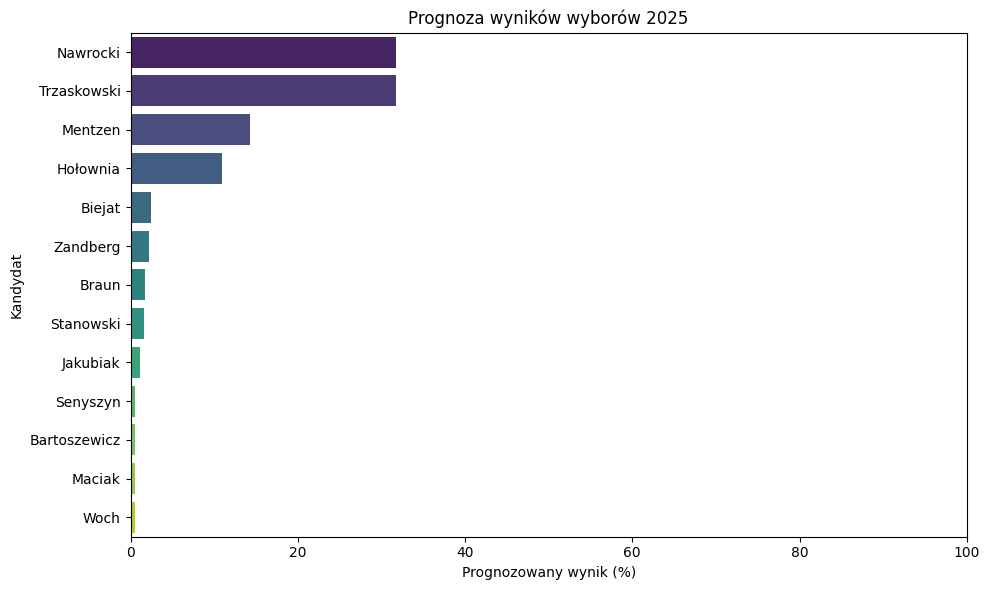

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(predictions_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=predictions_df,
        x='Prognoza (%)',
        y='Candidate',
        palette='viridis'
    )
    plt.title('Prognoza wyników wyborów 2025')
    plt.xlabel('Prognozowany wynik (%)')
    plt.ylabel('Kandydat')
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

# Wykres z wcześniej obliczonych prognoz
plot_predictions(final_predictions)
